<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/ALS_CF_For_Hotel_RS_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install surprise

     |████████████████████████████████| 11.8MB 255kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670907 sha256=3490952cd652f520df0710004d777a833bb8bb7efa939a4345ebc0c46ea9eeeb
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [4]:
!pip install implicit

     |████████████████████████████████| 1.1MB 5.1MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420110 sha256=6f6caaf2575166ee1c336c3315493236c09ae3d0074d32ea6de86c55134beef7
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, SlopeOne, NMF, SVDpp, KNNBaseline, CoClustering, accuracy
from surprise.model_selection import cross_validate
from __future__ import (absolute_import, division, print_function,unicode_literals)
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit
#import tensorrec

In [6]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving hotel_data_final.csv to hotel_data_final.csv


In [7]:
# Dataset is now stored in a Pandas Dataframe
import io
hotel_data = pd.read_csv(io.BytesIO(uploaded['hotel_data_final.csv']))

In [8]:
hotel_data.head()

,Hotel_id,Hotel,Address,City,Title,Users,Reviews,Rating,Hotel_Type,Price,Hotel_Category,User_id
0,0,La Quinta,5820 Walden Rd,Beaumont,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,1.0,NaN,NaN,"Lodging,Motels,Hotels,Meeting & Event Planning...",15400
1,1,The Point,Po Box 1327,Saranac Lake,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,5.0,NaN,NaN,"Hotels,Hotel,Restaurants",3702
2,1,The Point,Po Box 1327,Saranac Lake,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,5.0,NaN,NaN,"Hotels,Hotel,Restaurants",3738
3,1,The Point,Po Box 1327,Saranac Lake,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,5.0,NaN,NaN,"Hotels,Hotel,Restaurants",4593
4,1,The Point,Po Box 1327,Saranac Lake,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,2.0,NaN,NaN,"Hotels,Hotel,Restaurants",4657


In [9]:
hotel_data.shape

(24180, 12)

In [10]:
# Checking for missing values
pd.isnull(hotel_data).any()

Hotel_id          False
Hotel             False
Address           False
City              False
Title              True
Users             False
Reviews            True
Rating             True
Hotel_Type         True
Price              True
Hotel_Category    False
User_id           False
dtype: bool

In [11]:
hotel_data = hotel_data.dropna()
hotel_data = hotel_data.reset_index(drop=True)
print('Shape of dataset ',hotel_data.shape)
print(hotel_data.columns)

Shape of dataset  (21128, 12)
Index(['Hotel_id', 'Hotel', 'Address', 'City', 'Title', 'Users', 'Reviews',
       'Rating', 'Hotel_Type', 'Price', 'Hotel_Category', 'User_id'],
      dtype='object')


In [12]:
hotel_data.Rating.value_counts()

5.0    9805
4.0    6144
3.0    2814
2.0    1246
1.0    1119
Name: Rating, dtype: int64

In [14]:
List=[]
for i in np.arange(4,5.5, 1):
    M=hotel_data.loc[hotel_data[hotel_data.Rating==i].Hotel_id.value_counts().head(10).index,'Hotel']
    print('Rate: %f' %i)
    print(M)
    print(' ')

Rate: 4.000000
3113                         JW Marriott Atlanta Buckhead
9                                       Inn At Queen Anne
2189                             Best Western Mission Bay
56                                      Inn At Queen Anne
2968    Homewood Suites by Hilton Lake Buena Vista-Orl...
2741                                       Orchid Key Inn
38                                      Inn At Queen Anne
3018    Homewood Suites by Hilton Lake Buena Vista-Orl...
2822       Holiday Inn Express New York City Times Square
656          Doubletree By Hilton West Palm Beach Airport
Name: Hotel, dtype: object
 
Rate: 5.000000
2126                          Howard Johnson Inn Columbia
656          Doubletree By Hilton West Palm Beach Airport
38                                      Inn At Queen Anne
9                                       Inn At Queen Anne
1462                                  Gran Melia Victoria
2915                                           Hotel Abri
2984    Homew

In [15]:
hotel_data[hotel_data.Hotel_id==318].Rating.mean()# Average rating for 'Best Western Lamplighter Inn Suites at SDSU'

4.25

In [16]:
hotel_data[hotel_data.Hotel_id==296].Rating.mean() #Average rating for 'Nob Hill Hotel'


3.1333333333333333

The Hotels with the max number of ratings are:

In [17]:
MaxRating=hotel_data['Hotel_id'].value_counts().head(10)

In [18]:
hotel_data.loc[MaxRating.index,'Hotel']


3113                         JW Marriott Atlanta Buckhead
9                                       Inn At Queen Anne
656          Doubletree By Hilton West Palm Beach Airport
38                                      Inn At Queen Anne
2189                             Best Western Mission Bay
2126                          Howard Johnson Inn Columbia
2968    Homewood Suites by Hilton Lake Buena Vista-Orl...
2741                                       Orchid Key Inn
1300    Best Western Plus Arlington North Hotel and Su...
2822       Holiday Inn Express New York City Times Square
Name: Hotel, dtype: object

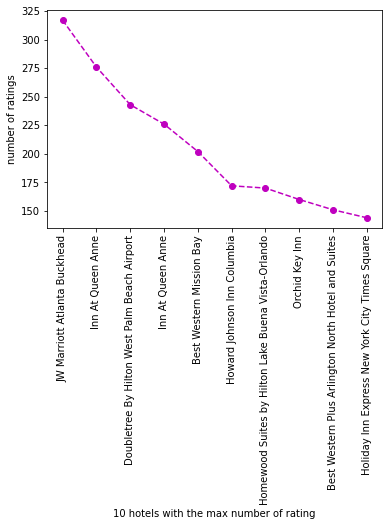

In [19]:
plt.plot(range(len(MaxRating)), MaxRating,'mo--')
plt.xticks(range(len(MaxRating)), hotel_data.loc[MaxRating.index,'Hotel'],rotation=90)
plt.xlabel('10 hotels with the max number of rating')
plt.ylabel('number of ratings')
plt.savefig('foo4.png',dpi=300,bbox_inches='tight')
plt.show()

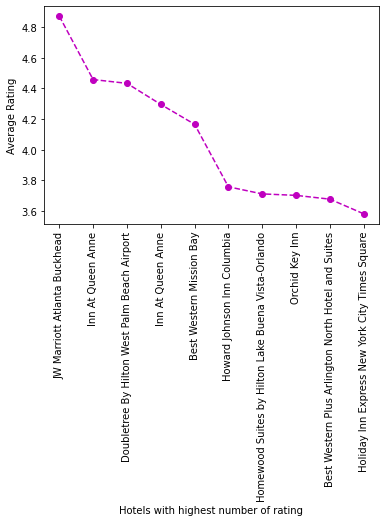

In [20]:
#The Hotels with the highest average rating are:
List5=[]
for i in MaxRating.index:
    List5.append(hotel_data[hotel_data.Hotel_id==i].Rating.mean())
plt.plot(range(len(List5)), sorted(List5,reverse=True),'mo--')
plt.xticks(range(len(List5)), hotel_data.loc[MaxRating.index,'Hotel'],rotation=90)
plt.xlabel('Hotels with highest number of rating')
plt.ylabel('Average Rating')
plt.savefig('foo5.png',dpi=300,bbox_inches='tight')
plt.show()

Number of hotels rated only once

In [21]:
MinRating=hotel_data['Hotel_id'].value_counts()
MinRating=MinRating[MinRating==1]
print('Number of hotels which are rated once:',hotel_data.loc[MinRating.index,'Hotel'].shape)

Number of hotels which are rated once: (238,)


Average rating of the ppl with highest number of rating



In [22]:
ID=hotel_data.User_id.value_counts().head(10) #UserID wih highest number of rating
List5=[]
for i in ID.index:
    List5.append(hotel_data[hotel_data.User_id==i]['Rating'].mean())

List5

[3.8502673796791442,
 3.5368898978433596,
 3.7300613496932513,
 3.6721311475409837,
 3.8076923076923075,
 3.8823529411764706,
 3.9555555555555557,
 3.96,
 3.8333333333333335,
 3.739130434782609]

Recommender System

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(hotel_data[['User_id','Hotel_id']],hotel_data['Rating'],test_size=0.25, 
                                                  random_state=55)

y_train=pd.DataFrame(y_train)
train=X_train.join(y_train)

y_test=pd.DataFrame(y_test)
test=X_test.join(y_test)

**1- Simple Recommender**

The Simple Recommender offers generalized recommnendations to every user based on hotel popularity, ratings, and City. The basic idea behind this recommender is that hotels that are more popular and more critically acclaimed will have a higher probability of being liked by the average Customers. This model does not give personalized recommendations based on the user.

So I sort the hotel based on their location, and I recommend the ones with the highest number of votes and the higher average rankings to the new Customers.

In [55]:
hotel_data=hotel_data[['User_id','Hotel_id','Rating','City','Hotel']]
hotel_data.head()

,User_id,Hotel_id,Rating,City,Hotel
0,710,2,2.0,Seattle,Inn At Queen Anne
1,710,2,1.0,Seattle,Inn At Queen Anne
2,710,2,2.0,Seattle,Inn At Queen Anne
3,710,2,3.0,Seattle,Inn At Queen Anne
4,710,2,3.0,Seattle,Inn At Queen Anne


The list of the 10 best Hotels to recommend in 'San Francisco' are:

In [25]:
a=hotel_data[hotel_data.City=='San Francisco'].Hotel_id.value_counts().head(30).index
count=0
for i in a:
    if (hotel_data[(hotel_data.Hotel_id==i)].Rating.mean()>4.1)&(count<10):
        count+=1
        print(count,':',hotel_data[(hotel_data.City=='San Francisco')&(hotel_data.Hotel_id==i)].Hotel.iloc[0])

1 : Galleria Park Hotel
2 : Hotel Abri
3 : The Orchard Garden Hotel
4 : The St. Regis San Francisco
5 : Columbus Motor Inn
6 : InterContinental San Francisco
7 : Hotel Nikko San Francisco
8 : Kensington Park Hotel
9 : San Francisco Marriott Marquis
10 : Inn San Francisco


The list of the 10 best Hotels to recommend in 'San Diego' are:

In [26]:
a=hotel_data[hotel_data.City=='San Diego'].Hotel_id.value_counts().head(30).index
count=0
for i in a:
    if (hotel_data[(hotel_data.Hotel_id==i)].Rating.mean()>3)&(count<10):
        count+=1
        print(count,':',hotel_data[(hotel_data.City=='San Diego')&(hotel_data.Hotel_id==i)].Hotel.iloc[0])

1 : Best Western Seven Seas
2 : Hampton Inn San Diego Del Mar
3 : Ocean Park Inn
4 : The Pearl Hotel
5 : Best Western Mission Bay
6 : Best Western Yacht Harbor Hotel
7 : Best Western San Diego/Miramar Hotel
8 : Best Western Plus Hacienda Hotel Old Town
9 : Best Western Plus Bayside Inn
10 : Quality Suites San Diego SeaWorld Area


In [27]:
a=hotel_data[hotel_data.City=='Bengaluru'].Hotel_id.value_counts().head(30).index
count=0
for i in a:
    if (hotel_data[(hotel_data.Hotel_id==i)].Rating.mean()>4)&(count<10):
        count+=1
        print(count,':',hotel_data[(hotel_data.City=='Bengaluru')&(hotel_data.Hotel_id==i)].Hotel.iloc[0])

1 : Shreyas Yoga Retreat
2 : Treebo Trend Rajathadri Palace
3 : Zone by the Park Electronic City
4 : Fortune Park JP Celestial
5 : Wonderla Resort
6 : Gokulam Grand Hotel & Spa
7 : Signature Club Resort
8 : Royal Orchid Resort & Convention Centre
9 : Sheraton Grand Bengaluru Whitefield Hotel & Convention Center
10 : Welcomhotel Bengaluru


**2- IMDB Weighted Rating Formula**

In [28]:
C=hotel_data.groupby('Hotel_id').Rating.mean().mean()
m=hotel_data.Hotel_id.value_counts().quantile(0.95)
print(' mean vote across the whole report (C):',C)
print('minimum votes required to be listed in the chart (m):',m)

 mean vote across the whole report (C): 3.997026417756089
minimum votes required to be listed in the chart (m): 61.59999999999991


In [30]:
a=hotel_data.Hotel_id.value_counts().sort_index()
b=hotel_data.groupby('Hotel_id').Rating.mean()

In [31]:
print('Number of Hotels which are qualified:',sum((a>m)&(b>C)))


Number of Hotels which are qualified: 47


In [32]:
a=pd.DataFrame(a.values,columns=['counts'],index=a.index)
b=pd.DataFrame(b.values,columns=['mean'],index=b.index)

In [33]:
df=pd.concat([a,b], axis=1, sort=False)
qualified = df[(df['counts'] >= m)  & (df['mean']>=C)]

print(qualified.shape[0],' Hotels are qualified')

47  Hotels are qualified


In [34]:
def weighted_rating(x):
    v = x['counts']
    R = x['mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False)

List1=[]
for i in qualified.head(30).index:
    List1.append(hotel_data[hotel_data.index==i]['Hotel'].values)
IMDBBest=pd.DataFrame(List1,columns=['Best to Recommend'])
IMDBBest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Best to Recommend
0,Howard Johnson Inn Columbia
1,Inn At Queen Anne
2,Doubletree By Hilton Hotel Bay City - Riverfront
3,Hotel Abri
4,Homewood Suites by Hilton Lake Buena Vista-Orl...
5,Gran Melia Victoria
6,Inn At Queen Anne
7,Homewood Suites by Hilton Baltimore
8,JW Marriott Atlanta Buckhead
9,Holiday Inn Express New York City Times Square


**Alternating Least Squares (ALS) Collaborative Filtering**

Alternating Least Squares (ALS) is a the model we’ll use to fit our data and find similarities. ALS is an iterative optimization process where we for every iteration try to arrive closer and closer to a factorized representation of our original data. We have our original matrix R of size u x i with our users, items and some type of feedback data. We then want to find a way to turn that into one matrix with users and hidden features of size u x f and one with items and hidden features of size f x i. In U and V we have weights for how each user/item relates to each feature. What we do is we calculate U and V so that their product approximates R as closely as possible: R ≈ U x V.

By randomly assigning the values in U and V and using least squares iteratively we can arrive at what weights yield the best approximation of R. The least squares approach in it’s basic forms means fitting some line to the data, measuring the sum of squared distances from all points to the line and trying to get an optimal fit by minimising this value.

With the alternating least squares approach we use the same idea but iteratively alternate between optimizing U and fixing V and vice versa. We do this for each iteration to arrive closer to R = U x V.

In [38]:
data=hotel_data
sparse_item_user = sparse.csr_matrix((data['Rating'].astype(float), (data['Hotel_id'], data['User_id'])))
sparse_user_item = sparse.csr_matrix((data['Rating'].astype(float), (data['Hotel_id'], data['User_id'])))

# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

model.fit(data_conf)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


In [40]:
#---------------------
# FIND SIMILAR HOTELS
#---------------------
Hotel_id = 318 #Best Western Lamplighter Inn Suites at SDSU
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(Hotel_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.Hotel_id.loc[data.Hotel_id == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'HotelId': a, 'Score': b})

for i in a:
    c.append(hotel_data[hotel_data.Hotel_id==i].Hotel.iloc[0])
recommendations['Hotel']=c
recommendations

,HotelId,Score,Hotel
0,318,0.219649,Best Western Lamplighter Inn Suites at SDSU
1,2292,0.170312,Home2 Suites By Hilton Greenville Airport
2,2894,0.161787,Americas Best Value Inn
3,431,0.113718,Hilton Garden Inn Atlanta Midtown
4,2554,0.106718,Stonebrook Lodge
5,2908,0.105427,Hilton Garden Inn DallasMarket Center
6,1416,0.104780,Best Western Dunkirk & Fredonia Inn
7,1776,0.101527,Worldmark Estes Park
8,2585,0.097784,Holiday Inn Express & Suites Anaheim Resort Area
9,1324,0.097642,"The Westin Poinsett, Greenville"


In [57]:
#---------------------
# FIND SIMILAR HOTELS
#---------------------
Hotel_id = 296 #Nob Hill Hotel
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(Hotel_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.Hotel_id.loc[data.Hotel_id == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'HotelId': a, 'Score': b})

for i in a:
    c.append(hotel_data[hotel_data.Hotel_id==i].Hotel.iloc[0])

recommendations['Hotel']=c
recommendations

,HotelId,Score,Hotel
0,296,0.176546,Nob Hill Hotel
1,713,0.167843,Barn Motor Inn
2,1291,0.167836,Magnuson Grand Hotel
3,2937,0.125239,Hilton Garden Inn San Diego Rancho Bernardo
4,2111,0.104498,Motel 6 Watsonville - Monterey Area
5,2620,0.104296,Americas Best Value Inn-arkansas City
6,1004,0.100965,"Country Inn & Suites By Carlson, Carlisle, PA"
7,1251,0.098050,Best Western Fort Lauderdale Airport/Cruise Port
8,1533,0.097838,Biddeford Motel
9,847,0.097774,Hotel Del Flores


In [49]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 1
User_id =20

# Use the implicit recommender.
recommended = model.recommend(User_id, sparse_user_item)

hotels = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    hotels.append(data.Hotel_id.loc[data.Hotel_id==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'HotelId': hotels, 'Score': scores})

for i in hotels:
    c.append(hotel_data[hotel_data.Hotel_id==i].Hotel.iloc[0])
recommendations['Hotel']=c
recommendations

,HotelId,Score,Hotel
0,9,0.950521,Doubletree By Hilton West Palm Beach Airport
1,38,0.385040,Doubletree By Hilton Hotel Bay City - Riverfront
2,1357,0.244432,InterContinental San Francisco
3,620,0.232435,SpringHill Suites Seattle Downtown/South Lake ...
4,1713,0.220871,Hampton Inn Hampton-Newport News
5,3025,0.209366,Breeze Suites
6,1963,0.208355,Courtyard Seattle Downtown/Lake Union
7,833,0.200237,Four Points by Sheraton Punta Gorda Harborside
8,1899,0.199080,Hampton Inn & Suites Dallas/Cockrell Hill I-30
9,2945,0.186421,Best Western Orlando Convention Center Hotel


In [53]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 1
User_id =906

# Use the implicit recommender.
recommended = model.recommend(User_id, sparse_user_item)

hotels = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    hotels.append(data.Hotel_id.loc[data.Hotel_id==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'HotelId': hotels, 'Score': scores})

for i in hotels:
    c.append(hotel_data[hotel_data.Hotel_id==i].Hotel.iloc[0])
recommendations['Hotel']=c
recommendations

,HotelId,Score,Hotel
0,2674,0.656241,Villa Paradiso
1,5,0.359177,Country Inn and Suites By Carlson Corbin
2,3127,0.352817,Holiday Inn Canyon De Chelly
3,2684,0.350387,"Mandarin Oriental, Miami"
4,2678,0.346196,The Charlesmark Hotel
5,2973,0.308582,Hotel Zetta San Francisco
6,2822,0.296789,French Market Inn
7,13,0.290184,La Quinta Inn and Suites Tucson - Reid Park
8,3118,0.289894,Fairfield Inn By Marriott Binghamton
9,1963,0.289178,Courtyard Seattle Downtown/Lake Union
